In [1]:
import pandas as pd
import pymongo
from pprint import pprint

# Basic usage of SACRED with PyMongo

In [2]:
# Connect to client
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

### List databases, collections, and select from them

In [3]:
print('databases:', client.list_database_names())
# client.drop_database('sacred_mnist_example')

databases: ['admin', 'config', 'hyperopt', 'local', 'sacred_mnist_example']


In [4]:
db = client['sacred_mnist_example']

In [5]:
print('Collections of {} db: {}'.format(db.name, db.list_collection_names()))


Collections of sacred_mnist_example db: ['runs', 'fs.files', 'fs.chunks', 'metrics']


### Example of a record (a "document") for a single experiment

In [ ]:
exp = list(db.runs.find())[-1]
pprint(exp.keys())
pprint('Example of a "document" that represents a single experiment:')
pprint('\n\n Example of configurations of several experiemts:')
pprint(exp)

### Example of configurations of several experiments

In [7]:
print('Example of configurations of several experiments:\n')
for i, exp in enumerate(list(db.runs.find())[0:3]):
    pprint(exp['config'])
    print('')
    

Example of configurations of several experiments:

{'batch_size': 32,
 'dropout_rate': 0.5,
 'epochs': 30,
 'fc_dim': 20,
 'lr': 0.0003,
 'seed': 0}

{'batch_size': 32,
 'dropout_rate': 0.4,
 'epochs': 30,
 'fc_dim': 300,
 'lr': 0.003,
 'seed': 0}

{'batch_size': 32,
 'dropout_rate': 0.5,
 'epochs': 30,
 'fc_dim': 100,
 'lr': 0.03,
 'seed': 0}



# Pandas + SACRED MongoDB

## Get a dataframe that summarize the experiements, according to a PANDAS query

In [8]:
from collections import OrderedDict
import pandas as pd
import re

def slice_dict(d, keys):
    """ Returns a dictionary ordered and sliced by given keys
        keys can be a list, or a CSV string
    """
    if isinstance(keys, str):
        keys = keys[:-1] if keys[-1] == ',' else keys
        keys = re.split(', |[, ]', keys)

    return dict((k, d[k]) for k in keys)

def sacred_to_df(db_runs, mongo_query=None, ):
    """
    db_runs is usually db.runs
    returns a dataframe that summarizes the experiments, where 
    config and info fields are flattened to their keys.
    Summary DF contains the following columns:
    _id, experiment.name, **config, result, **info, status, start_time
    """
    # get all experiment according to mongo query and represent as a pandas DataFrame    
    df = pd.DataFrame(list(db_runs.find(mongo_query)))

    # Take only the interesting columns
    df = df.loc[:, '_id, experiment, config, result, info, status, start_time'.split(', ')]

    def _summerize_experiment(s):
        """
        Take only the 
        """
        o = OrderedDict()
        o['_id'] = s['_id']
        o['name']=s['experiment']['name']
        o.update(s['config'])
        for key, val in s['info'].items():
            if key != 'metrics':
                o[key] = val 

        o.update(slice_dict(s.to_dict(), 'result, status, start_time'))
        return pd.Series(o)
    
    sum_list = []
    for ix, s in df.iterrows():
        sum_list.append(_summerize_experiment(s))
    df_summary = pd.DataFrame(sum_list).set_index('_id')
    
    return df_summary

### Filter according to some query

In [9]:
# Get the COMPLETED experiments with dim<=100 and val. accuracy > 85%
query = 'status=="COMPLETED" and val_acc>0.85 and fc_dim<=100'
df_summary = sacred_to_df(db.runs).query(query)
# Sort them in descending order (best performer is first).
df_summary = df_summary.sort_values('val_acc', ascending=False)
display(df_summary)

,name,batch_size,dropout_rate,epochs,fc_dim,lr,seed,test_acc,val_acc,result,status,start_time
_id,,,,,,,,,,,,
25,My_Experiment,32,0.3,30,100,0.00300,0,0.948,0.946,0.946,COMPLETED,2018-09-03 15:23:52.761
20,My_Experiment,32,0.2,30,30,0.00300,0,0.936,0.943,0.943,COMPLETED,2018-09-03 15:21:54.549
10,My_Experiment,32,0.5,30,100,0.00030,0,0.920,0.933,0.933,COMPLETED,2018-09-03 15:19:57.198
15,My_Experiment,32,0.1,30,100,0.00100,0,0.931,0.933,0.933,COMPLETED,2018-09-03 15:21:46.330
4,My_Experiment,32,0.8,30,30,0.00300,0,0.918,0.931,0.931,COMPLETED,2018-09-03 15:19:52.340
14,My_Experiment,32,0.2,30,100,0.00300,0,0.921,0.931,0.931,COMPLETED,2018-09-03 15:21:43.643
27,My_Experiment,32,0.3,30,100,0.00030,0,0.922,0.931,0.931,COMPLETED,2018-09-03 15:23:52.773
18,My_Experiment,32,0.1,30,60,0.00100,0,0.924,0.926,0.926,COMPLETED,2018-09-03 15:21:51.722
8,My_Experiment,32,0.1,30,30,0.00300,0,0.918,0.920,0.920,COMPLETED,2018-09-03 15:19:57.179


## Get raw experiments, according to the summary dataframe

In [10]:
def query_by_df(mongo_db_runs, df=None, ids=None):
    """
    Get raw experiments, according to the summary dataframe, or list of ids
    """
    if ids is None:
        ids = df.index.tolist()
        
    # Get a mongo iterator, according to the pandas DataFrame. 
    mongo_cursor = mongo_db_runs.find(dict(_id={'$in':ids}))
    
    # put raw results to a datafram
    df_raw_results = pd.DataFrame(list(mongo_cursor)).set_index('_id')
    
    # reorder results according to given dataframe because Cursor iterator does not preserve order from given dataframe 
    df_raw_results = df_raw_results.reindex(ids)
    return df_raw_results

### Show raw experiments artifacts

In [11]:
df_raw = query_by_df(db.runs, df_summary)
# show the results of the 'artifacts' field (resulting files)
display(df_raw.artifacts)
# who the dataframe that holds the raw experiments information
df_raw.head()

_id
25    [{'name': 'mnist_model.h5', 'file_id': 5b8d524...
20    [{'name': 'mnist_model.h5', 'file_id': 5b8d520...
10    [{'name': 'mnist_model.h5', 'file_id': 5b8d518...
15    [{'name': 'mnist_model.h5', 'file_id': 5b8d51f...
4     [{'name': 'mnist_model.h5', 'file_id': 5b8d517...
14    [{'name': 'mnist_model.h5', 'file_id': 5b8d520...
27    [{'name': 'mnist_model.h5', 'file_id': 5b8d524...
18    [{'name': 'mnist_model.h5', 'file_id': 5b8d51f...
8     [{'name': 'mnist_model.h5', 'file_id': 5b8d518...
16    [{'name': 'mnist_model.h5', 'file_id': 5b8d520...
1     [{'name': 'mnist_model.h5', 'file_id': 5b8d518...
17    [{'name': 'mnist_model.h5', 'file_id': 5b8d51f...
24    [{'name': 'mnist_model.h5', 'file_id': 5b8d522...
6     [{'name': 'mnist_model.h5', 'file_id': 5b8d518...
28    [{'name': 'mnist_model.h5', 'file_id': 5b8d524...
Name: artifacts, dtype: object

,artifacts,captured_out,command,config,experiment,format,heartbeat,host,info,meta,resources,result,start_time,status,stop_time
_id,,,,,,,,,,,,,,,
25,"[{'name': 'mnist_model.h5', 'file_id': 5b8d524...",INFO - My_Experiment - Running command 'main'\...,main,"{'batch_size': 32, 'dropout_rate': 0.3, 'epoch...","{'name': 'My_Experiment', 'base_dir': '/home/l...",MongoObserver-0.7.0,2018-09-03 15:25:01.225,"{'hostname': 'ctx19', 'os': ['Linux', 'Linux-3...",{'metrics': [{'id': '5b8d521cba49fca8c5f95a5c'...,"{'command': 'main', 'options': {'--force': Fal...",[],0.946,2018-09-03 15:23:52.761,COMPLETED,2018-09-03 15:25:01.193
20,"[{'name': 'mnist_model.h5', 'file_id': 5b8d520...",INFO - My_Experiment - Running command 'main'\...,main,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...","{'name': 'My_Experiment', 'base_dir': '/home/l...",MongoObserver-0.7.0,2018-09-03 15:23:47.508,"{'hostname': 'ctx19', 'os': ['Linux', 'Linux-3...",{'metrics': [{'id': '5b8d51b0ba49fca8c5f9530a'...,"{'command': 'main', 'options': {'--unobserved'...",[],0.943,2018-09-03 15:21:54.549,COMPLETED,2018-09-03 15:23:47.478
10,"[{'name': 'mnist_model.h5', 'file_id': 5b8d518...",INFO - My_Experiment - Running command 'main'\...,main,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...","{'name': 'My_Experiment', 'base_dir': '/home/l...",MongoObserver-0.7.0,2018-09-03 15:21:45.383,"{'hostname': 'ctx19', 'os': ['Linux', 'Linux-3...",{'metrics': [{'id': '5b8d5131ba49fca8c5f94bd0'...,"{'command': 'main', 'options': {'--enforce_cle...",[],0.933,2018-09-03 15:19:57.198,COMPLETED,2018-09-03 15:21:45.356
15,"[{'name': 'mnist_model.h5', 'file_id': 5b8d51f...",INFO - My_Experiment - Running command 'main'\...,main,"{'batch_size': 32, 'dropout_rate': 0.1, 'epoch...","{'name': 'My_Experiment', 'base_dir': '/home/l...",MongoObserver-0.7.0,2018-09-03 15:23:41.442,"{'hostname': 'ctx19', 'os': ['Linux', 'Linux-3...",{'metrics': [{'id': '5b8d519eba49fca8c5f9525b'...,"{'command': 'main', 'options': {'--name': None...",[],0.933,2018-09-03 15:21:46.330,COMPLETED,2018-09-03 15:23:41.394
4,"[{'name': 'mnist_model.h5', 'file_id': 5b8d517...",INFO - My_Experiment - Running command 'main'\...,main,"{'batch_size': 32, 'dropout_rate': 0.8, 'epoch...","{'name': 'My_Experiment', 'base_dir': '/home/l...",MongoObserver-0.7.0,2018-09-03 15:21:36.171,"{'hostname': 'ctx19', 'os': ['Linux', 'Linux-3...",{'metrics': [{'id': '5b8d512cba49fca8c5f94b87'...,"{'command': 'main', 'options': {'--unobserved'...",[],0.931,2018-09-03 15:19:52.340,COMPLETED,2018-09-03 15:21:36.139


### Load and evaluate the best model

#### Load the best model

In [18]:
import gridfs
fs = gridfs.GridFS(db)

def exp_artifacts_to_dict(list_artifacts):
    """ Converts a list of artifacts to a dictionary of {filename:file_id}  """
    d = {}
    for ar in list_artifacts:
        ar_name = ar['name']
        if ar_name in d.keys():
            raise(RuntimeError('%s artifact has duplicates'%ar_name))
        d[ar_name] = ar['file_id']
    return d    

In [19]:
import mnist_keras
mnist_keras.config_tf_session()

model_fname = 'mnist_model.h5'

# get file_id of best model from the first row in the df_raw DataFrame
gfs_best_model = exp_artifacts_to_dict(df_raw.artifacts.iloc[0])[model_fname]

# Can't load Keras model directly from GridFS. Therefore, we first copy the model 
# to /tmp (on OS filesystem), and then load it from there

# Read the model from GridFS
model_bytes = fs.get(gfs_best_model).read()
# Write the model to the OS filesystem
!mkdir -p /tmp/mnist_model
tmp_model_fname = '/tmp/mnist_model/model.h5'
with open(tmp_model_fname, 'wb') as f:
    f.write(model_bytes)

# Load the model to Keras, from OS filesystem
import tensorflow.keras as keras
model = keras.models.load_model(tmp_model_fname)
    

#### Evaluate data on the model

In [20]:
# Load data
_, _, x_train, y_train, x_val, y_val, x_test, y_test = mnist_keras.prepare_data()

x_train shape: (1000, 28, 28, 1)
1000 train samples
1000 val samples
1000 test samples


In [21]:
# Evaluate model
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print('val accuracy = ', val_accuracy)

1000/1000 [==============================] - 1s 730us/step
val accuracy =  0.946


### Plot learning curves of best model

In [22]:
import matplotlib.pyplot as plt
from bson.objectid import ObjectId

def metrics_to_name_id_dict(list_metrics):
    """ Converts a list of artifacts to a dictionary of {filename:file_id}  """
    d = {}
    for metric in list_metrics:
        metric_name = metric['name']
        if metric_name in d.keys():
            raise(RuntimeError('%s metric has duplicates'%metric_name))
        d[metric_name] = ObjectId(metric['id'])
    return d    
def experiment_metrics(db, exp_id):
    ex = db.runs.find_one(dict(_id=exp_id))
    metrics_id = metrics_to_name_id_dict(ex['info']['metrics'])
    metrics = {}
    for metric, id in metrics_id.items():        
        metrics[metric] = db.metrics.find_one(dict(_id=id))
    return metrics
    
def plot_experiment_metrics(db, exp_id, metrics_to_plot=None, rename_metrics={}):
    metrics = experiment_metrics(db, exp_id)
    if metrics_to_plot is None:
        metrics_to_plot = sorted(list(metrics.keys()))
    
    legend = []
    for name in metrics_to_plot:
        plt.plot(metrics[name]['steps'], metrics[name]['values'])
        # rename the metric if a new name is given
        legend.append(rename_metrics.get(name, name))
    return legend
    


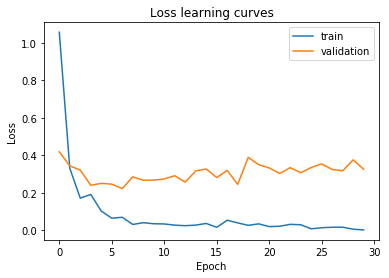

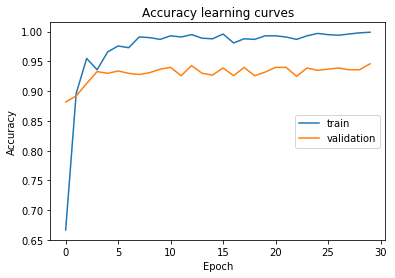

In [27]:
plt.figure()
legend = plot_experiment_metrics(db, int(df_summary.index[0]), ['loss', 'val_loss'],
                                rename_metrics=dict(loss='train', val_loss='validation'))
plt.legend(legend);
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss learning curves')

plt.figure()
legend = plot_experiment_metrics(db, int(df_summary.index[0]), ['acc', 'val_acc'], 
                                 rename_metrics=dict(acc='train', val_acc='validation'))
plt.legend(legend, loc='center right');
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy learning curves');



## Delete model files ("artifacts") from all experiments except best  3 

In [28]:
import gridfs
def delete_artifact(name_to_delete, experiment_id, db):
    fs = gridfs.GridFS(db)
    ex = db.runs.find_one(dict(_id=experiment_id))
    updated_artifacts = []
    for i, artifact in enumerate(ex['artifacts']):
        if artifact['name'] == name_to_delete:
            fs.delete(artifact['file_id'])
            if fs.exists(artifact['file_id']):
                raise RuntimeError('Failed to delete artifact, {}'.format(artifact))
            else:
                # deleted successfuly, then don't add to updated_artifacts list 
                pass
        else:
            updated_artifacts.append(artifact)
    ex['artifacts'] = updated_artifacts
    db.runs.update_one({'_id':experiment_id}, {"$set": ex})


In [29]:
# Delete all model files except of best 3 models
for ex_id in df_summary.index.tolist()[3:]:
    delete_artifact('mnist_model.h5', ex_id, db)

In [30]:
# Show results
df_raw = query_by_df(db.runs, df_summary)
df_raw.artifacts

_id
25    [{'name': 'mnist_model.h5', 'file_id': 5b8d524...
20    [{'name': 'mnist_model.h5', 'file_id': 5b8d520...
10    [{'name': 'mnist_model.h5', 'file_id': 5b8d518...
15                                                   []
4                                                    []
14                                                   []
27                                                   []
18                                                   []
8                                                    []
16                                                   []
1                                                    []
17                                                   []
24                                                   []
6                                                    []
28                                                   []
Name: artifacts, dtype: object